In [174]:
import numpy as np
import scipy as sp
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import matplotlib.pyplot as plt
%matplotlib inline

Nonequilibrium
https://www.pnas.org/content/110/45/E4185

Sequence:
https://www.sciencedirect.com/science/article/pii/S0896627310000917

## Hopfield model

## $\tau \frac { d u _ { i } } { d t } = - u _ { i }(t) + \sum _ { j = 1 } ^ { N } T _ { ij } f _ { j } \left( u _ { j } (t)\right) + I _ { i }(t)$

-Hopfield: $T_{ij}$ is PSD

-Functional feedforward: $T_{ij}$ is non-normal, with off-diagonal terms shown in Schur decomposition

-Seuqnece activity: $T_{ij}$ has dominating elements along $i^{th}$ rows and the convarinace matrix would be eye-like

In [102]:
###Tij matrix
N = 20
temp = np.random.randn(1,N)
T = np.dot(temp.T,temp)
T = T/N
# rv = np.random.randn(1,N)
# u,s,v = np.linalg.svd(np.dot(temp.T,temp))
# K = 3
# T = np.zeros((N,N))
# for ii in range(K):
#     T = T + np.outer(u[:,ii],u[:,ii])
# T = T/(N)


In [3]:
###functional feedforward
temp = np.random.randn(1,N)
T = np.dot(temp.T,temp)
u,s,v = np.linalg.svd(T)
temp2 = np.random.randn(N,N)
ss = np.diag(s) + np.triu(temp2, k=1)*50  #with feedforward term in Schur decomposition
T = u @ ss @ v
T = T/N

In [123]:
###sequence?
temp = np.random.randn(1,N)
T = np.dot(temp.T,temp)
temp2 = np.eye(N)
rr = np.arange(N)
np.random.shuffle(rr)
temp3 = np.take(temp2, rr, axis=0)  #seqeunce feedforward matrix
T = T + temp3*25
T = T/N

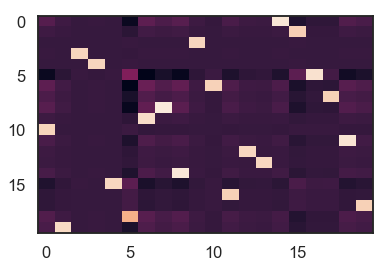

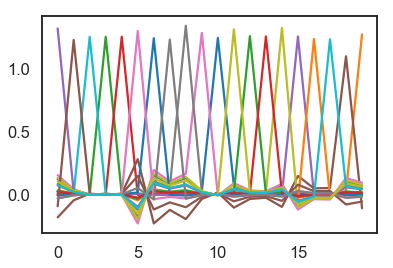

In [124]:
plt.imshow(T,aspect='auto')
plt.figure()
plt.plot(T);

In [165]:
###Nonlinearity
def NL(u,the):
    return np.array([min(np.max(ui-the,0),10) for ui in u]) #ReLu

###Dynamics
TT = 5
dt = 0.01
time = np.arange(0,TT,dt)
u = np.zeros((N,len(time)))
u[:,0] = np.random.randn(N)
tau = 0.05  #time scale
the = 0  #threshold
beta = .3  #global inhibition

rep = 20  #instantiations
us = np.zeros((rep,N,len(time)))
for rr in range(rep):
    u[:,:-1] = 0
    u[:,0] = np.random.randn(N)#*np.std(u[:,-1])*1.5  #initial condition (scaled by a proper range!)
    u[:,-1] = 0
    for tt in range(0,len(time)-1):
        u[:,tt+1] = u[:,tt] + dt*(-u[:,tt] + np.dot(T,NL(u[:,tt]-beta*np.sum(u[:,tt]),the)))/tau + np.random.randn(N)*1.5
        #u[:,tt+1] = u[:,tt] + dt*(-u[:,tt] + NL(np.dot(T,u[:,tt])-beta*np.sum(u[:,tt]),the))/tau + np.random.randn(N)*1.  
    us[rr,:,:] = u
    #us.append(u)  ##???
    #plt.figure()
    #plt.imshow(u,aspect='auto')
    

Text(0, 0.5, 'activity')

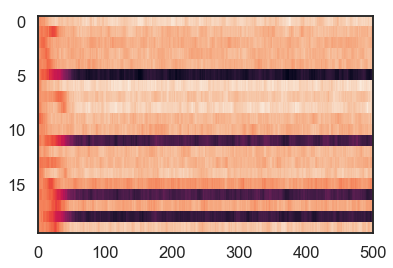

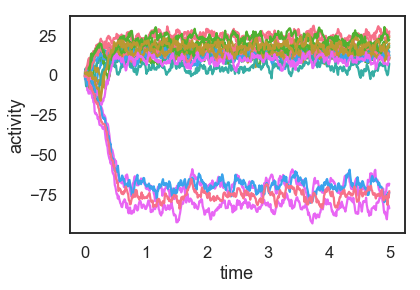

In [175]:
plt.imshow(u,aspect='auto')
plt.figure()
plt.plot(time,u.T);
plt.xlabel('time')
plt.ylabel('activity')

Text(0, 0.5, '|Y(freq)|')

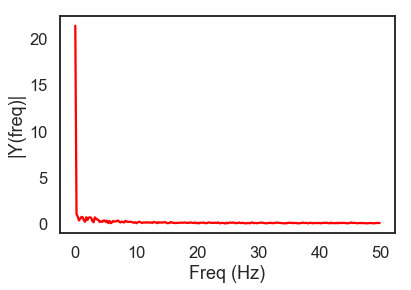

In [176]:
###Spectrum
Fs = int(1/dt);  # sampling rate
Ts = 1.0/Fs; # sampling interval

n = u.shape[1] # length of the signal
k = np.arange(n)
Tf = n/Fs
frq = k/Tf # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(u[0,:])/n # fft computing and normalization
Y = Y[range(int(n/2))]

plt.plot(frq[:],abs(Y)[:],'r') # plotting the spectrum
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')


Text(0, 0.5, 'activity')

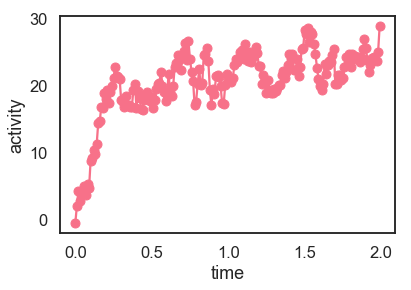

In [177]:
plt.plot(time[:200],u[0,:200].T,'-o');
plt.xlabel('time')
plt.ylabel('activity')

## Energy landscape

## $U(u) = -ln(P_{ss}(u))$

(20, 10000)

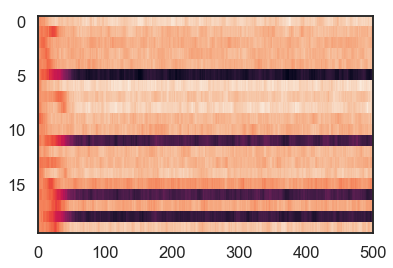

In [178]:
data = np.array(us)  #rep X neu X time array
plt.imshow(np.squeeze(data[-1,:,:]),aspect='auto')

data = np.transpose(data, (0, 2, 1));   #swap dimensions
data = np.reshape(data,(rep*len(time),N));  #combine trials and time
data = data.T  #move cell in front
data.shape

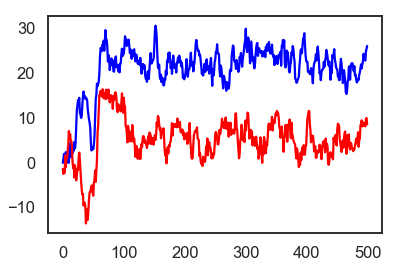

In [179]:
#checking trials
plt.plot(data[0,4500:5000],'b')
plt.plot(data[0,3500:4000],'r')

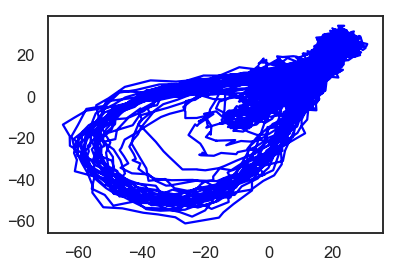

In [345]:
xx = data[0,:]
yy = data[6,:]

plt.plot(xx,yy,'b')

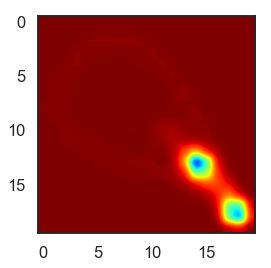

In [346]:
###landscape
Xs = np.arange(min(xx), max(xx), 5)
Ys = np.arange(min(yy), max(yy), 5)
# Xs = np.arange(np.mean(xx)-np.std(xx), np.mean(xx)+np.std(xx), 1)
# Ys = np.arange(np.mean(yy)-np.std(yy), np.mean(yy)+np.std(yy), 1)
Pss, xedges, yedges = np.histogram2d(xx, yy, bins=[len(Xs),len(Ys)],normed='True')
U = -np.log(Pss.T+10**10)

plt.imshow(U,interpolation='gaussian',cmap='jet')

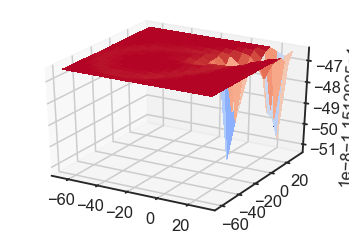

In [347]:
###3D landscape
X, Y = np.meshgrid(Xs, Ys)
Pss, xedges, yedges = np.histogram2d(xx, yy, bins=[len(Xs),len(Ys)],normed='True')
U = -np.log(Pss.T+10**5)

# Plot the surface
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, U, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


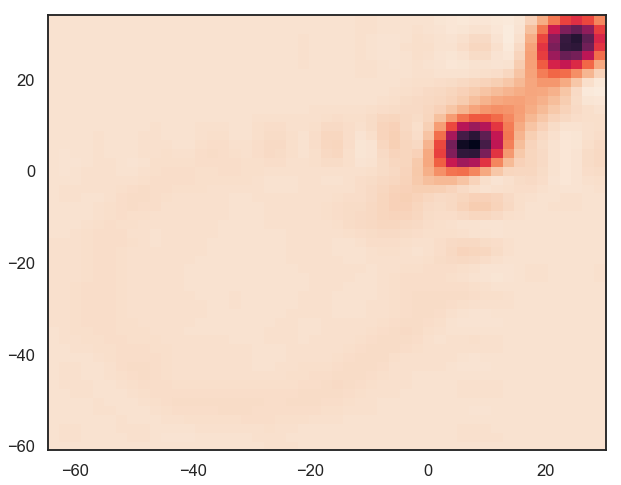

In [348]:
### Gaussian Process regression for energy landscape of Hopfield network

from itertools import product
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D

xy = np.vstack((X.reshape(-1),Y.reshape(-1))).T

y = U.reshape(-1)
y = (y-np.mean(y))*1000000  #reasonable range?

# Input space
x1 = np.linspace(xy[:,0].min(), xy[:,0].max()) #p
x2 = np.linspace(xy[:,1].min(), xy[:,1].max()) #q
x = (np.array([x1, x2])).T

kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))  #
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

gp.fit(xy, y)

x1x2 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2, return_std=True)

X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50)
Zp = np.reshape(y_pred,(50,50))

# alternative way to generate equivalent X0p, X1p, Zp
# X0p, X1p = np.meshgrid(x1, x2)
# Zp = [gp.predict([(X0p[i, j], X1p[i, j]) for i in range(X0p.shape[0])]) for j in range(X0p.shape[1])]
# Zp = np.array(Zp).T

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.pcolormesh(X0p, X1p, Zp)


/Users/Macintosh/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 0, 'Energy U')

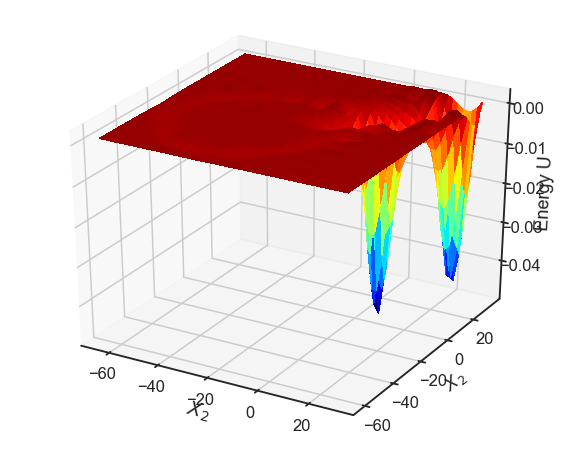

In [351]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.pcolormesh(X0p, X1p, Zp)

ax = fig.add_subplot(111, projection='3d')            
ax.plot_surface(X0p, X1p, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)

ax.set_xlabel('$X_2$', fontsize=20, rotation=150)
ax.set_ylabel('$X_2$')
ax.set_zlabel('Energy U')


In [198]:
###PCA test
Xp = data.copy()
C = np.cov(Xp)
uu,ss,vv = np.linalg.svd(C)
PCs = np.dot(uu[:,:3].T,Xp)

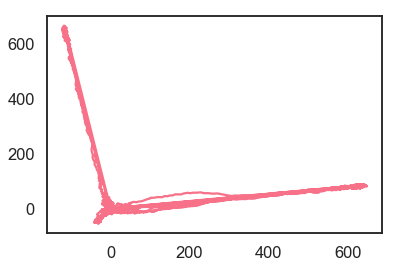

In [199]:
plt.plot(PCs[0,:],PCs[1,:])

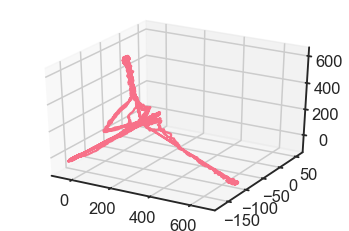

In [200]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')
ax.plot3D(PCs[1,:], PCs[2,:], PCs[0,:])